# Histopathologic Cancer Detection

![](https://forums.fast.ai/uploads/default/original/2X/b/b97e0e49affeee3a85118192204d011c0379c7d1.jpeg)

[image-source](https://forums.fast.ai/uploads/default/original/2X/b/b97e0e49affeee3a85118192204d011c0379c7d1.jpeg)
# Acknowledgements
This kernel contains excerpts from and was inspired by the following other kernels:
* https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai
* https://www.kaggle.com/CVxTz/cnn-starter-nasnet-mobile-0-9709-lb
* https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb
* https://www.kaggle.com/artgor/simple-eda-and-model-in-pytorch

# Introduction
This kernel is an exemplary presentation of a simple exploratory data analysis (EDA) and a tutorial on creating your first model for this challenge. It is targeted at beginners.

Running it you will be able to 
* take a look at the data for the challenge and its features
* train a basic convolutional neural network on all of the data (many of the other kernels only train on parts of the data)
* create your first submission ( LB ~0.93)

# Contents
1. Useful python modules
2. The challenge and the data
3. Loading the data
4. EDA
5. Creating a simple keras model
6. Training and validating the model
7. Creating a submission

# 1. Modules
We utilize a variety of modules in this kernel. Most of these provide way more functionality than we need, but they are all handy:
* [glob](https://docs.python.org/3/library/glob.html) for easily finding matching filenames
* [numpy](https://www.numpy.org/) - because it is _the_ math module for most things
* [pandas](https://pandas.pydata.org/) - a powerful module for data structures and analysis
* [keras](https://keras.io/) - a high-level deep learning API, in our case to ease TensorFlow usage
* [cv2](https://opencv-python-tutro****als.readthedocs.io/en/latest/py_tutorials/py_setup/py_intro/py_intro.html#intro) - for image processing (we'll just use it for loading images)
* [tqdm](https://tqdm.github.io/) - a minimalistic yet powerful and easy to use progress bar
* [matplotlib](https://matplotlib.org/) - a plotting module

In [1]:
#Load the modules
from glob import glob 
import numpy as np
import pandas as pd
import keras,cv2,os

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D

from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt

import gc #garbage collection, we need to clean up and save memory

Using TensorFlow backend.


# 2. The challenge and the data
Technically, the goal of this challenge is a binary classification task for images, meaning we want to divide images into two classes. Practically, microscopic images of lymph node tissue with a resolution of 96x96 pixels are provided and we should provide a probability indicating if the images show metastatic cancer tissue in the 32x32 center region of the image.

About 220,000 labeled images are provided for training and about 57,000 make up the test set.

Let's start by loading the data and having a look at some of the images.

# 3. Loading the data
We'll start by creating a pandas data frame containing the path of all the files in the `train_path` folder and then read the matching labels from the provided csv file.

## Load the labels and filenames

In [2]:
#set paths to training and test data
path = "../input/" #adapt this path, when running locally
train_path = path + 'train/'
test_path = path + 'test/'

df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split('/')[3].split(".")[0]) # keep only the file names in 'id'
labels = pd.read_csv(path+"train_labels.csv") # read the provided labels
df = df.merge(labels, on = "id") # merge labels and filepaths
df.head(10) # print the first three entrys

,path,id,label
0,../input/train/292faf631c5ff5741bb46b04e4eacce...,292faf631c5ff5741bb46b04e4eacceb272d8c8b,0
1,../input/train/5a61b93a34e2a37869a4e83e964169a...,5a61b93a34e2a37869a4e83e964169ad3d1e3753,0
2,../input/train/139e7bd057aafacf7cce59490104ccf...,139e7bd057aafacf7cce59490104ccf281a3fa98,0
3,../input/train/5adf6b5ce28b15f585b8d53fc8d3716...,5adf6b5ce28b15f585b8d53fc8d3716182026ab4,0
4,../input/train/abf7a7eb3e7bc917e766670eebd7f44...,abf7a7eb3e7bc917e766670eebd7f440c500ee4d,0
5,../input/train/156f6a50526bdfdfae44a804c6fabce...,156f6a50526bdfdfae44a804c6fabce6562482e0,1
6,../input/train/35246d6405f080a57505e2e4d8ec0fa...,35246d6405f080a57505e2e4d8ec0fa9df33e7e3,0
7,../input/train/b2b1c081319ac56e011bfe368fb3033...,b2b1c081319ac56e011bfe368fb30336fa1ddce1,1
8,../input/train/f2f7753410bd17f63f1fb6570e2614d...,f2f7753410bd17f63f1fb6570e2614d6092c2754,1
9,../input/train/3cf3e17777c2b73fe7d11f09857f32c...,3cf3e17777c2b73fe7d11f09857f32c9a418a378,0


## Load the images

Now, we will load some of the images. As [interactive kernels with GPU](https://www.kaggle.com/docs/kernels#the-kernels-environment) currently offer about 14 GB of RAM, we will take care to keep the images in the uint8 format (i.e. pixel values are integers between 0 and 255) to reduce the memory footprint. Processing of the images often requires converting them to float32, which would require additional space.

We'll declare a function to load a set number of images and then load 10000 images.

In [3]:
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    #convert the labels to a numpy array too
    y = np.squeeze(df.as_matrix(columns=['label']))[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
          
    return X,y

In [4]:
df.shape

(220025, 3)

In [5]:
# Load 10k images
N=10000
X,y = load_data(N=N,df=df) 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


# 4. Exploratory Data Analysis (EDA)

The purpose of this EDA is to 
* Take a look at the images
* Understand the distribution of the two classes (no cancer cells / cancer cells)
* Have a look at some image features (RGB channel distributions, mean brightness)

## Let's plot some example images with their assigned label (0 - no cancer cells, 1 - cancer cells):

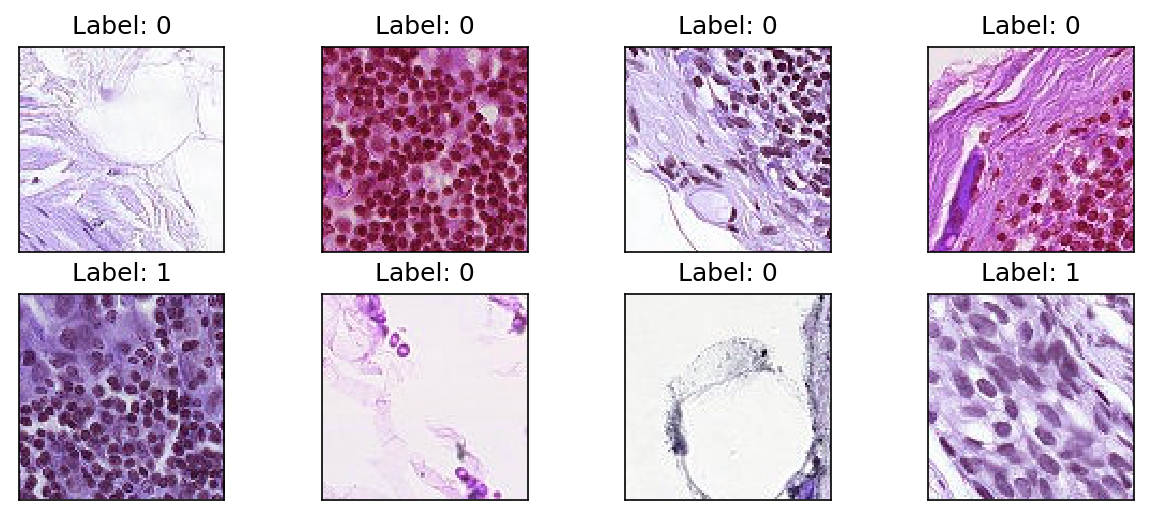

In [6]:
fig = plt.figure(figsize=(10, 4), dpi=150)
np.random.seed(100) #we can use the seed to get a different set of random images
for plotNr,idx in enumerate(np.random.randint(0,N,8)):
    ax = fig.add_subplot(2, 8//2, plotNr+1, xticks=[], yticks=[]) #add subplots
    plt.imshow(X[idx]) #plot image
    ax.set_title('Label: ' + str(y[idx])) #show the label corresponding to the image

So, for most people (like me) there is no easy way to discern which images contain cancer cells. There is a [variety of things](https://www.nature.com/articles/nmeth.4397.pdf) one can look at to get a deeper insight into the data.

## Let's starting looking at the data distribution

We'll start by looking at how often the classes are represented. 

Text(0, 0.5, '# of samples')

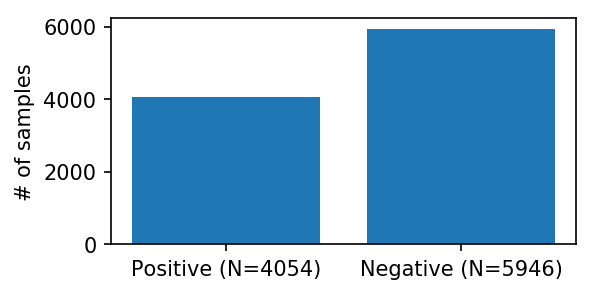

In [7]:
fig = plt.figure(figsize=(4, 2),dpi=150)
plt.bar([1,0], [(y==0).sum(), (y==1).sum()]); #plot a bar chart of the label frequency
plt.xticks([1,0],["Negative (N={})".format((y==0).sum()),"Positive (N={})".format((y==1).sum())]);
plt.ylabel("# of samples")

So, we have about a 60 / 40 split of negative to positive samples in the data. This is important because it means that a trivial classifier, that just labels every sample as negative, would achieve an accuracy of 60%. Possible countermeasures to avoid a bias in the classifier and improve stability during training are, e.g., [over- and undersampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis).

## Let's start looking at each class individually

We'll now split the data into positive and negative samples to get an idea what makes the classes unique. Such an analysis can often provide insight into possible [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) possibilities or which data transformations may be useful.

In [8]:
positive_samples = X[y == 1]
negative_samples = X[y == 0]

Now, we will compare the distribution of pixel values for each color channel (RGB) individually and all channels together

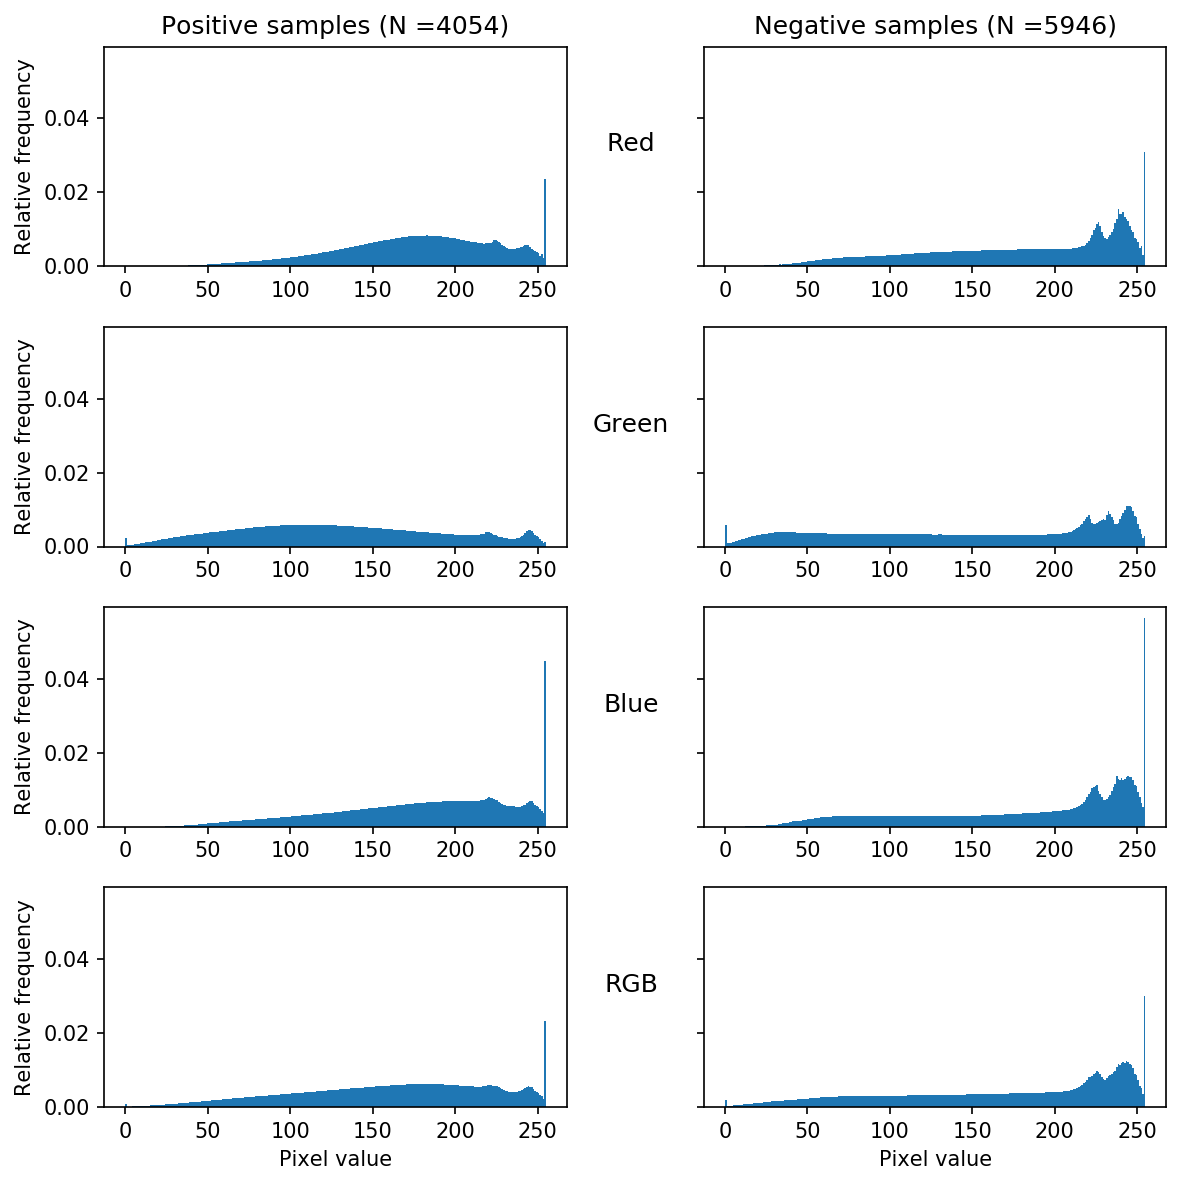

In [9]:
nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

#RGB channels
axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

#All channels
axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)

#Set image labels
axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
fig.tight_layout()

So we can already spot differences in the distributions of all channels individually and together between positive and negative samples: 
* Negative samples seem to have higher, i.e. brighter, pixel values in general and especially in the green color channel. 
* Interestingly, the positive samples have a darker green channel than red and blue while this is not true for the negative samples. However, very dark pixels are for both sample sets mostly only present in the green channel.
* Furthermore, note the relatively high frequency of the pixel value 255. Looking at the data above we can see, that these can likely be attributed to the bright white image regions present in some images. They seem to be present in both positive and negative samples similarly frequently.

Now, let's switch perspective and look at the distribution of mean image brightness, i.e. mean image pixel values. Note, previously we were averaging over all pixel values in the positive and negative samples. Now, we will take the mean of each individual image and look at that distribution.

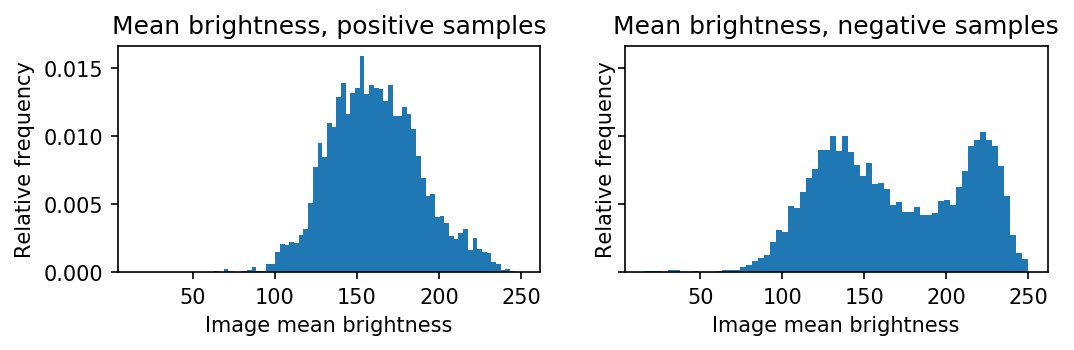

In [10]:
nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

Once again, we can spot pretty obvious differenes between the positive and negative samples. The distribution of mean brightness for the positive samples looks almost like a normal distribution around a brightness of 150. The negative samples, however, seem to follow some bimodal distribution with peaks around 140 and 225. 

**Conclusions:** 
* There are some easily spotted differences in the distributions of pixel values and mean image brightness between positive and negative samples. This is good, because whatever model we will use can likely use this. 
* Some of the images seem to contain very bright regions, which are likely artifacts of the recording process. We might have to find a way to deal with them. They are almost equally distributed between positive and negative samples and, hence, probably not easily usable as a feature.
* We have about 50% more negative than positive samples. This might require adjustments.

# Setup the model
We will now focus on creating a simple model for this problem. This is usually the point, where you would want to start considering our previous conclusions, but to keep it simple, we will assume, we did not draw any meaningful conclusions. As the data is - in comparison to other Kaggle challenges - relatively well balanced and accesible, this should be ok. You can use the insight to craft a better model later!

Let's start by loading all the data, not just a subset as before. This will likely require a few minutes. However, we only need to do it once.

In [11]:
gc.collect()
sample = 0.9
N = int(df["path"].size * sample) # get the number of images in the training data set
X,y = load_data(N=N,df=df)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


We will use the garbage collector and unbind some variables to free up space in our RAM.

In [12]:
#Collect garbage
positives_samples = None
negative_samples = None
gc.collect();

Now, we will split the data into a [training and validation set](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets). Due to the RAM limitations, we will just do this in-place by specifying an index at which we will split. We'll use 80% of the data for training and 20% to validate that our model can generalize to new data. After that, to avoid any influence of a possible previous sorting of data we will shuffle the data (in-place).

In [13]:
'''
training_portion = 0.8 # Specify training/validation ratio
split_idx = int(np.round(training_portion * y.shape[0])) #Compute split idx

np.random.seed(42) #set the seed to ensure reproducibility

#shuffle
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]
'''

'\ntraining_portion = 0.8 # Specify training/validation ratio\nsplit_idx = int(np.round(training_portion * y.shape[0])) #Compute split idx\n\nnp.random.seed(42) #set the seed to ensure reproducibility\n\n#shuffle\nidx = np.arange(y.shape[0])\nnp.random.shuffle(idx)\nX = X[idx]\ny = y[idx]\n'

In [14]:
from sklearn.model_selection import train_test_split
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2, shuffle=True)

In [15]:
del X
del y
gc.collect();

Let's declare our neural network architecture now. This kernel uses [keras](https://keras.io/), which makes it very easy to setup a neural network and start training it.

The model architecture is taken from [another kernel](https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb). It is a relatively simple convolutional neural network with three blocks of [convolutional layers, batch normalization, pooling and dropout](https://cs231n.github.io/convolutional-networks/).

In [16]:
#just some network parameters, see above link regarding the layers for details
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

#dropout is used for regularization here with a probability of 0.3 for conv layers, 0.5 for the dense layer at the end
dropout_conv = 0.3
dropout_dense = 0.5

from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

#initialize the model
model = Sequential()

#now add layers to it

#conv block 1
model.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

#conv block 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#conv block 3
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#a fully connected (also called dense) layer at the end
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

#finally convert to values of 0 to 1 using the sigmoid activation function
model.add(Dense(1, activation = "sigmoid"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


To start training with keras we need to [compile](https://keras.io/models/model/#compile) our model. We will use a batch size of 50, i.e., feed the network 50 images at once. Further, we will use [binary crossentropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) as loss function and the [Adam optimizer](ruder.io/optimizing-gradient-descent/index.html). We set the [learning rate](https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10) of 0.001 for now.

As output we will get the classification accuracy of the model.

In [ ]:
batch_size = 32
epochs = 30

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.01), 
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(monitor='val_acc', mode='max', filepath='model.hdf5', verbose=2, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=0, mode='max')

history = model.fit(x = xtrain, y = ytrain, validation_data=(xvalid, yvalid), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[checkpointer, earlyStopping])

Train on 149616 samples, validate on 37405 samples
Epoch 1/30
 - 109s - loss: 0.1871 - acc: 0.9300 - val_loss: 0.4267 - val_acc: 0.8559

Epoch 00001: val_acc improved from -inf to 0.85590, saving model to model.hdf5
Epoch 2/30
 - 106s - loss: 0.1839 - acc: 0.9318 - val_loss: 0.3201 - val_acc: 0.8778

Epoch 00002: val_acc improved from 0.85590 to 0.87780, saving model to model.hdf5
Epoch 3/30
 - 107s - loss: 0.1794 - acc: 0.9337 - val_loss: 0.2512 - val_acc: 0.9073

Epoch 00003: val_acc improved from 0.87780 to 0.90731, saving model to model.hdf5
Epoch 4/30
 - 106s - loss: 0.1747 - acc: 0.9356 - val_loss: 0.5253 - val_acc: 0.8422

Epoch 00004: val_acc did not improve from 0.90731
Epoch 5/30
 - 106s - loss: 0.1721 - acc: 0.9373 - val_loss: 0.2131 - val_acc: 0.9188

Epoch 00005: val_acc improved from 0.90731 to 0.91875, saving model to model.hdf5
Epoch 6/30
 - 106s - loss: 0.1690 - acc: 0.9381 - val_loss: 0.2449 - val_acc: 0.9021

Epoch 00006: val_acc did not improve from 0.91875
Epoch 7/

In [ ]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

We are now ready to start training our model!

# 6. Train and validate the model
We will now train the model for three epochs (should take ~20mins). That means the model will have performed a [forward and backward pass](https://cs231n.github.io/optimization-2/) for each image in the training exactly three times.

To do so, we will split the training data in batches and feed one batch after another into the network. [The batch size is a critical parameter for training a neural network](https://cs231n.github.io/neural-networks-3/#baby). 

Keras can do the splitting automatically for you, but, I thought, this way it is more transparent what is happening.

In [ ]:
'''
#normally you would want to reshuffle the data between epochs, we don't as we split in-place into training/validation
epochs = 10 #how many epochs we want to perform
for epoch in range(epochs):
    #compute how many batches we'll need
    iterations = np.floor(split_idx / batch_size).astype(int) #the floor makes us discard a few samples here, I got lazy...
    loss,acc = 0,0 #we will compute running loss and accuracy
    with trange(iterations) as t: #display a progress bar
        for i in t:
            start_idx = i * batch_size #starting index of the current batch
            x_batch = X[start_idx:start_idx+batch_size] #the current batch
            y_batch = y[start_idx:start_idx+batch_size] #the labels for the current batch

            metrics = model.train_on_batch(x_batch, y_batch) #train the model on a batch

            loss = loss + metrics[0] #compute running loss
            acc = acc + metrics[1] #compute running accuracy
            t.set_description('Running training epoch ' + str(epoch)) #set progressbar title
            t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2)) #display metrics
'''

Now, to verify that our model also works with data it hasn't seen yet, we will perform a validation epoch, i.e., check the accuracy on the validation set without further training the network. This is achieved using the [`test_on_batch` function](https://keras.io/models/sequential/#test_on_batch).

In [ ]:
'''
#compute how many batches we'll need
iterations = np.floor((y.shape[0]-split_idx) / batch_size).astype(int) #as above, not perfect
loss,acc = 0,0 #we will compute running loss and accuracy
with trange(iterations) as t: #display a progress bar
    for i in t:
        start_idx = i * batch_size #starting index of the current batch
        x_batch = X[start_idx:start_idx+batch_size] #the current batch
        y_batch = y[start_idx:start_idx+batch_size] #the labels for the current batch
        
        metrics = model.test_on_batch(x_batch, y_batch) #compute metric results for this batch using the model
        
        loss = loss + metrics[0] #compute running loss
        acc = acc + metrics[1] #compute running accuracy
        t.set_description('Running training') #set progressbar title
        t.set_description('Running validation')
        t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2))
        
print("Validation loss:",loss / iterations)
print("Validation accuracy:",acc / iterations)
'''

# 7. Create a submission
Well, now that we have a trained a model, we can create a submission by predicting the labels of the test data and see, where we are at in the leaderboards!

Let's just first clear up some RAM. The creation of the submission is a modified version of the on presented in [this kernel](https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb)

In [ ]:
del xtrain
del xvalid
del ytrain
del yvalid
gc.collect();

In [ ]:
from keras.models import load_model

model = load_model('model.hdf5')

base_test_dir = path + 'test/' #specify test data folder
test_files = glob(os.path.join(base_test_dir,'*.tif')) #find the test file names
submission = pd.DataFrame() #create a dataframe to hold results
file_batch = 5000 #we will predict 5000 images at a time
max_idx = len(test_files) #last index to use
for idx in range(0, max_idx, file_batch): #iterate over test image batches
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]}) #add the filenames to the dataframe
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[3].split(".")[0]) #add the ids to the dataframe
    test_df['image'] = test_df['path'].map(cv2.imread) #read the batch
    K_test = np.stack(test_df["image"].values) #convert to numpy array
    
    predictions = model.predict(K_test,verbose = 1) #predict the labels for the test data
    test_df['label'] = predictions #store them in the dataframe
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head() #display first lines

In [ ]:
submission.to_csv("submission.csv", index = False, header = True) #create the submission file